# visualize global performance 

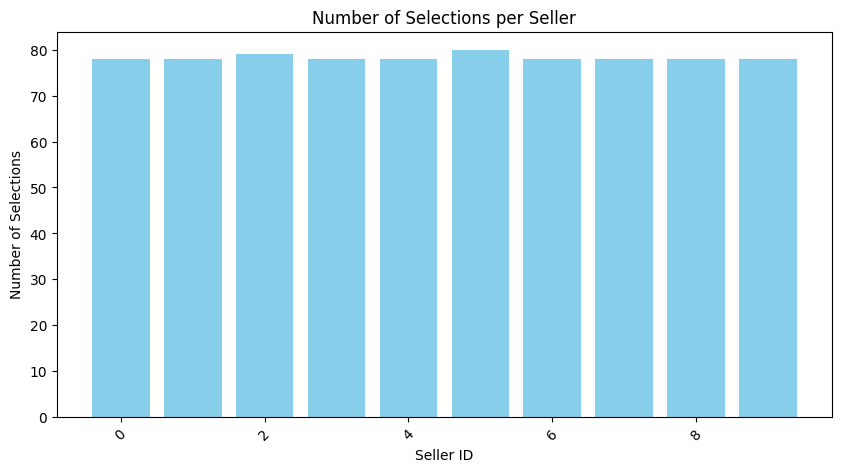

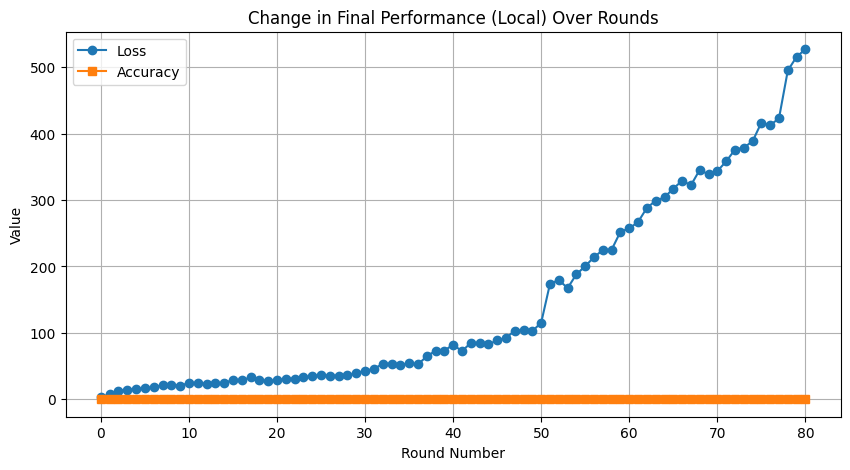

In [4]:
import torch
import matplotlib.pyplot as plt
import collections


# Load PyTorch checkpoint file

def visualize_global(data):
    # Track seller selection counts
    seller_selection_counts = collections.Counter()

    # Track final performance changes
    round_numbers = []
    final_loss = []
    final_acc = []

    # Process each round
    for round_data in data:
        round_numbers.append(round_data["round_number"])
        final_loss.append(round_data["final_perf_local"]["loss"])
        final_acc.append(round_data["final_perf_local"]["acc"])

        # Count selections per seller
        for seller in round_data["used_sellers"]:
            seller_selection_counts[seller] += 1

    # Plot seller selection counts
    plt.figure(figsize=(10, 5))
    plt.bar(seller_selection_counts.keys(), seller_selection_counts.values(), color="skyblue")
    plt.xlabel("Seller ID")
    plt.ylabel("Number of Selections")
    plt.title("Number of Selections per Seller")
    plt.xticks(rotation=45)
    plt.show()

    # Plot final loss and accuracy changes over rounds
    plt.figure(figsize=(10, 5))
    plt.plot(round_numbers, final_loss, label="Loss", marker="o")
    plt.plot(round_numbers, final_acc, label="Accuracy", marker="s")
    plt.xlabel("Round Number")
    plt.ylabel("Value")
    plt.title("Change in Final Performance (Local) Over Rounds")
    plt.legend()
    plt.grid()
    plt.show()


In [ ]:
data = torch.load("results_visual/n_seller_10_n_adv_0_strength_1.0/market_log_round_80.ckpt", weights_only=False )  # Change filename as needed


# Visualize local

In [ ]:
import torch
import glob
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Directory where your ckpt files are stored (adjust as needed)
log_dir = "./"  # assuming they are in the current directory

# Find all files matching the pattern local_log_*.ckpt
file_pattern = os.path.join(log_dir, "local_log_*.ckpt")
files = glob.glob(file_pattern)

all_records = []

# Loop over each file and read the records
for filename in files:
    # Extract client id from filename (assuming pattern: local_log_{client_id}.ckpt)
    base = os.path.basename(filename)
    client_id = int(base.split("_")[-1].split(".")[0])
    
    # Load the checkpoint file (assuming it's saved with torch.save)
    # Adjust the loading method if your ckpt files use a different format.
    records = torch.load(filename)
    
    # Assume records is a list of dictionaries for each round
    # with keys: "round_number", "is_selected", etc.
    for record in records:
        record["client_id"] = client_id
        all_records.append(record)

# Convert the list of records to a pandas DataFrame
df = pd.DataFrame(all_records)

# Ensure that the is_selected field is integer (1 for True, 0 for False)
df["is_selected"] = df["is_selected"].astype(int)

# Pivot the DataFrame: rows = round_number, columns = client_id, values = is_selected
pivot_df = df.pivot(index="round_number", columns="client_id", values="is_selected")
pivot_df = pivot_df.sort_index()

# Create a heatmap of the selection status over rounds
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap="YlGnBu", annot=True, fmt="d", linewidths=0.5, linecolor='gray')
plt.title("Selection Pattern for All Clients Over Rounds")
plt.xlabel("Client ID")
plt.ylabel("Global Round")
plt.show()


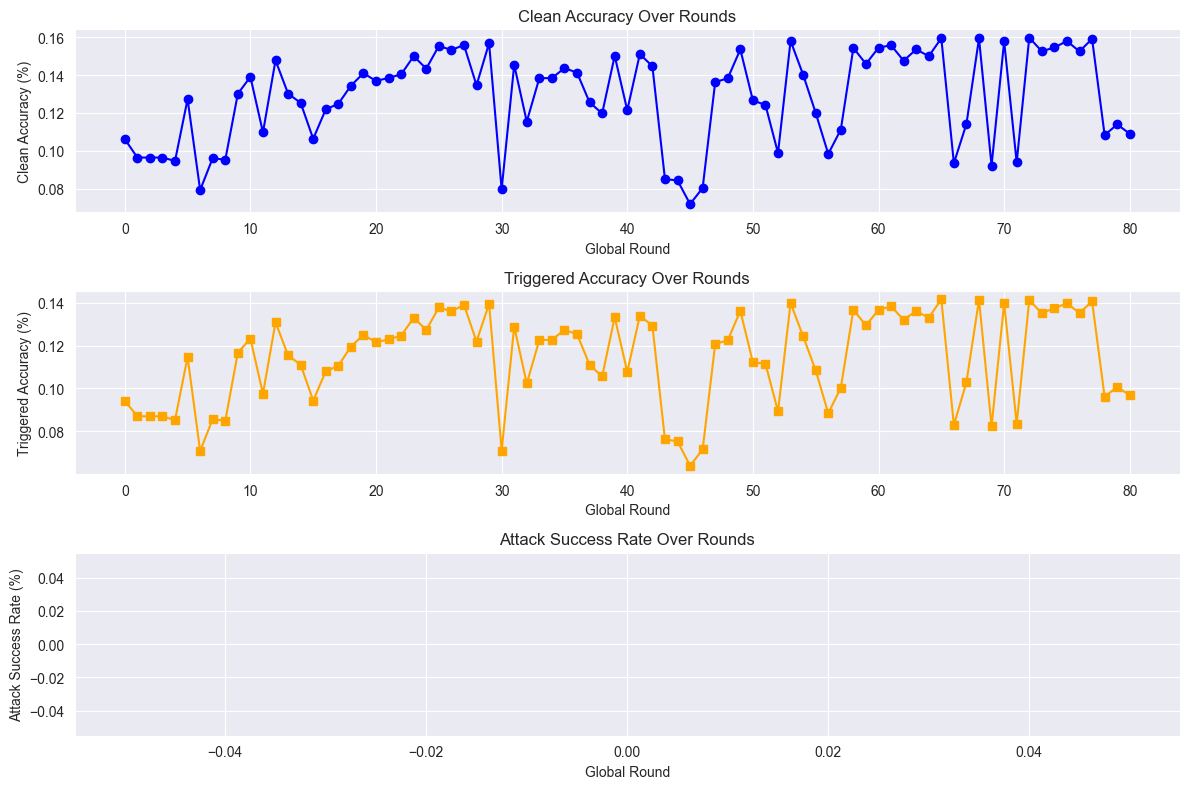

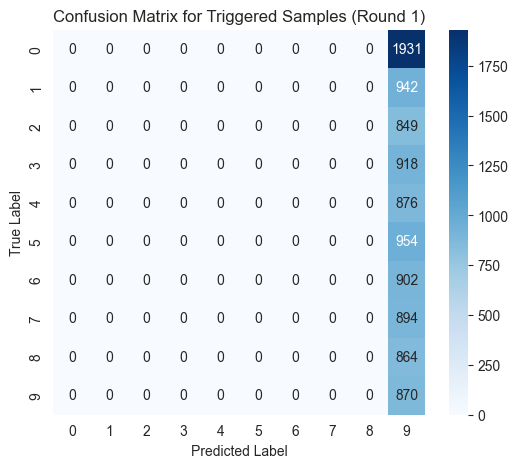

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import torch

# Assume round_records is your list of dictionaries, one per round.
# Each record is assumed to have a structure similar to:
# {
#    "round_number": <int>,
#    "extra_info": {
#         "poison_metrics": {
#              "clean_accuracy": float,
#              "triggered_accuracy": float,
#              "attack_success_rate": float,
#              "confusion_matrix_triggered": np.array or similar
#         },
#         ... other info ...
#    },
#    ... other keys ...
# }

def extract_metrics(round_records):
    rounds = []
    clean_acc = []
    triggered_acc = []
    asr = []
    confusion_matrices = []

    for record in round_records:
        round_num = record.get("round_number", None)
        if round_num is None:
            continue
        rounds.append(round_num)
        poison_metrics = record.get("extra_info", {}).get("poison_metrics", {})
        clean_acc.append(poison_metrics.get("clean_accuracy", np.nan))
        triggered_acc.append(poison_metrics.get("triggered_accuracy", np.nan))
        asr.append(poison_metrics.get("attack_success_rate", np.nan))
        confusion_matrices.append(poison_metrics.get("confusion_matrix_triggered", None))
    return rounds, clean_acc, triggered_acc, asr, confusion_matrices

def plot_attack_metrics(rounds, clean_acc, triggered_acc, asr):
    plt.figure(figsize=(12, 8))
    
    # Plot Clean Accuracy
    plt.subplot(3,1,1)
    plt.plot(rounds, clean_acc, marker='o', linestyle='-', color='blue')
    plt.xlabel("Global Round")
    plt.ylabel("Clean Accuracy (%)")
    plt.title("Clean Accuracy Over Rounds")
    plt.grid(True)
    
    # Plot Triggered Accuracy
    plt.subplot(3,1,2)
    plt.plot(rounds, triggered_acc, marker='s', linestyle='-', color='orange')
    plt.xlabel("Global Round")
    plt.ylabel("Triggered Accuracy (%)")
    plt.title("Triggered Accuracy Over Rounds")
    plt.grid(True)
    
    # Plot Attack Success Rate
    plt.subplot(3,1,3)
    plt.plot(rounds, asr, marker='^', linestyle='-', color='red')
    plt.xlabel("Global Round")
    plt.ylabel("Attack Success Rate (%)")
    plt.title("Attack Success Rate Over Rounds")
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

def visualize_confusion_matrix(conf_matrix, round_number):
    """
    Visualize a confusion matrix (assumed to be a numpy array) for a given round.
    """
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix for Triggered Samples (Round {round_number})")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

round_records = []  # e.g., load from a file or variable

# For demonstration, here's a dummy record list
dummy_conf_matrix = np.array([[50, 10], [5, 35]])
round_records = torch.load("results_visual/n_seller_10_n_adv_0_strength_1.0/market_log_round_80.ckpt", weights_only=False )  


# Extract metrics
rounds, clean_acc, triggered_acc, asr, conf_matrices = extract_metrics(round_records)

# Plot the main metrics over rounds
plot_attack_metrics(rounds, clean_acc, triggered_acc, asr)

# Optionally, visualize confusion matrix for a selected round, e.g., round 2
# You can loop over or choose a round based on some criteria.
selected_round_index = 1  # corresponds to round 2 in our dummy data
if conf_matrices[selected_round_index] is not None:
    visualize_confusion_matrix(conf_matrices[selected_round_index], rounds[selected_round_index])
